In [2]:
import os
import numpy as np
import math
import scipy
import pandas as pd

import lmfit
from scipy.stats import norm, chi2 
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline 
from scipy.optimize import root_scalar

# Create interpolation functions

import matplotlib.pyplot as plt

In [56]:
custom_palette = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
    '#999999', '#e41a1c', '#dede00'
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_palette)

plt.rcParams["font.family"] = "Times New Roman"     # Normal text
plt.rcParams["mathtext.fontset"] = "custom"        # Custom math font
plt.rcParams["mathtext.rm"] = "Times New Roman"    # Roman font for math
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

# Optional: increase default font size
plt.rcParams["font.size"] = 12

In [4]:
def linear(x, m, b):
    return m*x + b 

## From day 3 data

In [33]:
c = 299792458

lambdas = np.array([365.0, 404.7, 435.8, 546.1, 577.5])*1e-9
lambdas_err = np.array([2.0, 2.0, 2.0, 2.0, 2.0])*1e-9

nus = c/lambdas
nus_err = c*lambdas_err/(lambdas**2)


slopes = np.array([
    -1.98232752, -2.53234476, -3.60265574, -2.93559039, -1.05248960 
])

slopes_err = np.array([
    0.05958201, 0.07168559, 0.21108246, 0.17780369, 0.11847482
])

slopes_relerr = np.array([
    .0301, .0283, .0586, .0606, .1126
])

intercepts = np.array([
    2.84778064, 2.73315739, 3.18776759, 0.89954346, 0.19366735
])

intercepts_err = np.array([
    0.07125710, 0.06481403, 0.15623832, 0.02944923,  0.01070043
])

intercepts_relerr = np.array([
    .0250, .0237, .0490, .0327, .0553
])

cov = np.array(
    [ -0.9974, -0.9974, -0.9979, -0.9358, -0.9259]
)

V_stop_res = -intercepts/slopes

V_stop_relerr = np.sqrt(
    slopes_relerr**2 + intercepts_relerr**2 + 2*slopes_relerr*intercepts_relerr*cov
)


V_stop_err_stat = V_stop_res*V_stop_relerr

V_stop_err_sys = np.array(
    [0.012, 0.009, 0.007, 0.009, 0.015]
)

V_stop_err = np.sqrt(V_stop_err_stat**2 + V_stop_err_sys**2)


print(V_stop_res)
print(V_stop_relerr)
print(V_stop_err)

[1.43658432 1.07929909 0.88483825 0.30642676 0.1840088 ]
[0.00547019 0.00496464 0.01020881 0.03213798 0.06485444]
[0.01434414 0.01047434 0.01142794 0.01334099 0.01916808]


<ErrorbarContainer object of 3 artists>

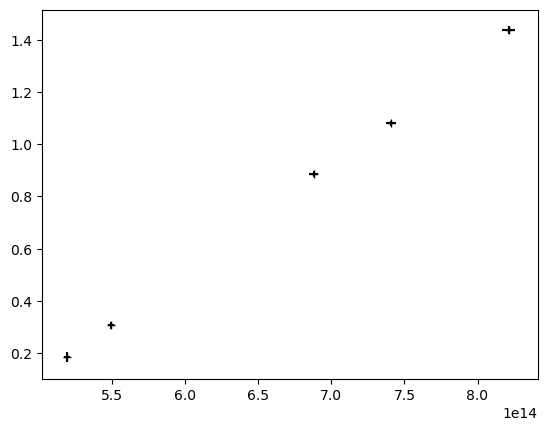

In [34]:
plt.errorbar(nus, V_stop_res, xerr = nus_err, yerr =  V_stop_err, fmt = 'k+' )

In [68]:
from scipy.odr import ODR, Model, RealData

def f(B, x):
    return B[0] * x + B[1]  # slope * x + intercept

linear = Model(f)
data = RealData(nus/1e14, V_stop_res, nus_err/1e14, V_stop_err)

odr = ODR(data, linear, beta0=[0., -2.])
out = odr.run()

out.pprint()

slope, intercept = out.beta
cov = out.cov_beta      # covariance matrix [[var_m, cov],[cov, var_b]]
var_m, var_b = cov[0,0], cov[1,1]
cov_mb = cov[0,1]

Beta: [ 0.41111482 -1.95067206]
Beta Std Error: [0.00471606 0.0310235 ]
Beta Covariance: [[ 6.06795555e-05 -3.93916007e-04]
 [-3.93916007e-04  2.62582522e-03]]
Residual Variance: 0.3665351689347589
Inverse Condition #: 0.06835777180437248
Reason(s) for Halting:
  Sum of squares convergence


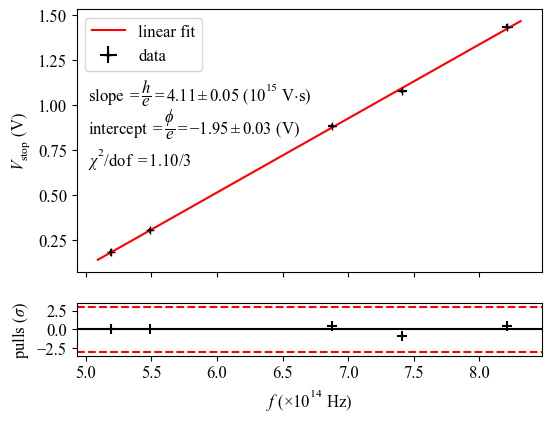

In [128]:
####plotting
x_data = nus/1e14
y_data = V_stop_res
y_eval = f(out.beta, x_data)

x_err = nus_err/1e14
y_err = V_stop_err 


x_fit = np.linspace(min(x_data)-0.1, max(x_data)+0.1)
y_fit = f(out.beta, x_fit)


pull = (y_data-y_eval)/(np.sqrt(y_err**2 + out.beta[0]**2 *x_err**2 ))

# --- Create figure with 2 panels ---
fig, (ax_main, ax_pull) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [5, 1]},
    figsize=(6, 4.5)
)

# --- Top: data + fit ---
ax_main.errorbar(x_data, y_data, xerr =x_err, yerr = y_err, fmt = 'k+', label = 'data' )
ax_main.plot(x_fit, y_fit, color='red', label= 'linear fit')
ax_main.set_ylabel(r"$V_\mathrm{stop}$ (V)")
ax_main.legend(loc="upper left", bbox_to_anchor=(0, 1))

# --- Bottom: pulls ---
ax_pull.scatter(x_data, pull, color='black', marker="+", s=50)
ax_pull.axhline(0, color='black', linestyle='-')
ax_pull.axhline(3, color='red', linestyle='--')
ax_pull.axhline(-3, color='red', linestyle='--')
ax_pull.set_xlabel(r"$f$ ($\times 10^{14}$ Hz)")
ax_pull.set_ylabel(r"pulls ($\sigma$)")
ax_pull.set_ylim(-3.5,3.5)

ax_main.annotate(r"slope $=\dfrac{h}{e}=4.11 \pm 0.05$ ($ 10^{15}$ V$\cdot$s)", xy=(0.025,0.650), xycoords="axes fraction" ) 
ax_main.annotate(r"intercept $=\dfrac{\phi}{e}=-1.95 \pm 0.03$ (V) ", xy=(0.025,0.525), xycoords="axes fraction" ) 
ax_main.annotate(r"$\chi^2$/dof $= 1.10/3$", xy=(0.025,0.4), xycoords="axes fraction" ) 


#plt.tight_layout()
plt.savefig("Vstop-f.pdf")
plt.show()


In [129]:
chi2 = np.sum(pull**2)

In [87]:
print(chi2, chi2/3)

1.0996055068042767 0.3665351689347589


## From day 2 data

In [131]:
lambdas = np.array([365.0, 435.8, 546.1, 577.5])*1e-9
lambdas_err = np.array([2.0, 2.0, 2.0, 2.0])*1e-9

nus = c/lambdas
nus_err = c*lambdas_err/(lambdas**2)


slopes = np.array([
    -2.24752995 , -3.64573315, -3.94434360, -0.77117855
])


slopes_relerr = np.array([
    .0421, .0817, .0484, .2423
])

intercepts = np.array([
    3.24279803, 3.32799158, 1.33308644, 0.19653552
])


intercepts_relerr = np.array([
    .0358, .0703, .0312, .1013
])

cov = np.array(
    [ -0.9987, -0.9985, -0.9719, -0.8540
])

V_stop_res = -intercepts/slopes

V_stop_relerr = np.sqrt(
    slopes_relerr**2 + intercepts_relerr**2 + 2*slopes_relerr*intercepts_relerr*cov
)


V_stop_err_stat = V_stop_res*V_stop_relerr

V_stop_err_sys = np.array(
    [0, 0, 0, 0]
)

V_stop_err = np.sqrt(V_stop_err_stat**2 + V_stop_err_sys**2)


print(V_stop_res)
print(V_stop_relerr)
print(V_stop_err)

[1.4428275  0.91284563 0.33797422 0.25485086]
[0.00660369 0.01213221 0.0195117  0.16446318]
[0.00952798 0.01107484 0.00659445 0.04191358]


In [132]:

linear = Model(f)
data = RealData(nus/1e14, V_stop_res, nus_err/1e14, V_stop_err)

odr = ODR(data, linear, beta0=[0., -2.])
out = odr.run()

out.pprint()

slope, intercept = out.beta
cov = out.cov_beta      # covariance matrix [[var_m, cov],[cov, var_b]]
var_m, var_b = cov[0,0], cov[1,1]
cov_mb = cov[0,1]

Beta: [ 0.40598139 -1.88709831]
Beta Std Error: [0.00554055 0.03484331]
Beta Covariance: [[ 6.12357406e-05 -3.79925827e-04]
 [-3.79925827e-04  2.42180168e-03]]
Residual Variance: 0.5013029395899876
Inverse Condition #: 0.06714449345058499
Reason(s) for Halting:
  Sum of squares convergence


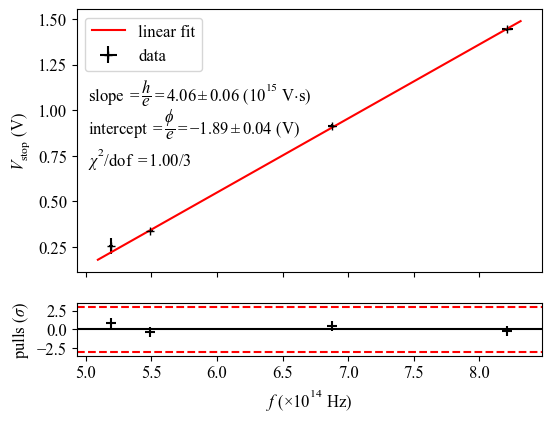

In [137]:
####plotting
x_data = nus/1e14
y_data = V_stop_res
y_eval = f(out.beta, x_data)

x_err = nus_err/1e14
y_err = V_stop_err 


x_fit = np.linspace(min(x_data)-0.1, max(x_data)+0.1)
y_fit = f(out.beta, x_fit)


pull = (y_data-y_eval)/(np.sqrt(y_err**2 + out.beta[0]**2 *x_err**2 ))

# --- Create figure with 2 panels ---
fig, (ax_main, ax_pull) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [5, 1]},
    figsize=(6, 4.5)
)

# --- Top: data + fit ---
ax_main.errorbar(x_data, y_data, xerr =x_err, yerr = y_err, fmt = 'k+', label = 'data' )
ax_main.plot(x_fit, y_fit, color='red', label= 'linear fit')
ax_main.set_ylabel(r"$V_\mathrm{stop}$ (V)")
ax_main.legend(loc="upper left", bbox_to_anchor=(0, 1))

# --- Bottom: pulls ---
ax_pull.scatter(x_data, pull, color='black', marker="+", s=50)
ax_pull.axhline(0, color='black', linestyle='-')
ax_pull.axhline(3, color='red', linestyle='--')
ax_pull.axhline(-3, color='red', linestyle='--')
ax_pull.set_xlabel(r"$f$ ($\times 10^{14}$ Hz)")
ax_pull.set_ylabel(r"pulls ($\sigma$)")
ax_pull.set_ylim(-3.5,3.5)

ax_main.annotate(r"slope $=\dfrac{h}{e}=4.06 \pm 0.06$ ($ 10^{15}$ V$\cdot$s)", xy=(0.025,0.650), xycoords="axes fraction" ) 
ax_main.annotate(r"intercept $=\dfrac{\phi}{e}=-1.89 \pm 0.04$ (V) ", xy=(0.025,0.525), xycoords="axes fraction" ) 
ax_main.annotate(r"$\chi^2$/dof $= 1.00/3$", xy=(0.025,0.4), xycoords="axes fraction" ) 


#plt.tight_layout()
plt.savefig("Vstop-f.pdf")
plt.show()


In [135]:
chi2 = np.sum(pull**2)

In [136]:
print(chi2)

1.0026058791799826
